In [35]:
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics

seed = 7
np.random.seed(seed)

def printmd(string):
    display(Markdown(string))
    
    
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


%  matplotlib inline

In [2]:
#adult = pd.read_csv('adult.csv')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']

train = pd.read_csv('adult_data.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test = pd.read_csv('adult_test.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')


adult = pd.concat([test,train])
adult.reset_index(inplace = True, drop = True)

---
# 1. Preliminary Data Analysis

In [3]:
# Setting all the categorical columns to type category
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')
    
printmd('## 1.1. Columns and their types')
print(adult.info())

## 1.1. Columns and their types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  int64   
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  int64   
 3   education        48842 non-null  category
 4   educational-num  48842 non-null  int64   
 5   marital-status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital-gain     48842 non-null  int64   
 11  capital-loss     48842 non-null  int64   
 12  hours-per-week   48842 non-null  int64   
 13  native-country   48842 non-null  category
 14  income           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None


In [4]:
# Top 5 records
printmd('## 1.2. Data')
adult.head()

## 1.2. Data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
printmd('## 1.3. Summary Statistics')

adult.describe()

## 1.3. Summary Statistics

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
printmd('## 1.4. Missing values')
for i,j in zip(adult.columns,(adult.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        printmd(str(i) + ': ' + str(j) + ' records')



## 1.4. Missing values

workclass: 2799 records

occupation: 2809 records

native-country: 857 records

### Treating Missing Values by predicting them

I fill the missing values in each of the three columns by predicting their values. For each of the three columns, I use all the attributes (including 'income') as independent variables and treat that column as the dependent variable, making it a multi-class classification task. I use three classification algorithms, namely, logistic regression, decision trees and random forest to predict the class when the value is missing (in this case a '?'). I then take a majority vote amongst the three classifiers to be the class of the missing value. In case of a tie, I pick the majority class of that column using the entire dataset.

In [7]:
# Create one hot encoding of the categorical columns in the data frame.
def oneHotCatVars(df, df_cols):
    
    df_1 = adult_data = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

In [8]:
printmd('### 1.4.1. Filling in missing values for Attribute workclass')

test_data = adult[(adult.workclass.values == '?')].copy()
test_label = test_data.workclass

train_data = adult[(adult.workclass.values != '?')].copy()
train_label = train_data.workclass

test_data.drop(columns = ['workclass'], inplace = True)
train_data.drop(columns = ['workclass'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult.workclass.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.workclass.values == '?'),'workclass'] = overall_pred.values
print(adult.workclass.value_counts())
print(adult.workclass.unique())

### 1.4.1. Filling in missing values for Attribute workclass

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Private             36445
Self-emp-not-inc     3872
Local-gov            3142
State-gov            1983
Self-emp-inc         1695
Federal-gov          1432
Never-worked          252
Without-pay            21
?                       0
Name: workclass, dtype: int64
['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Never-worked', 'Without-pay']
Categories (8, object): ['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov',
                         'Self-emp-inc', 'Never-worked', 'Without-pay']


In [9]:
printmd('### 1.4.2. Filling in missing values for Occupation occupation')

test_data = adult[(adult.occupation.values == '?')].copy()
test_label = test_data.occupation

train_data = adult[(adult.occupation.values != '?')].copy()
train_label = train_data.occupation

test_data.drop(columns = ['occupation'], inplace = True)
train_data.drop(columns = ['occupation'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult.occupation.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.occupation.values == '?'),'occupation'] = overall_pred.values
print(adult.occupation.value_counts())
print(adult.occupation.unique())

### 1.4.2. Filling in missing values for Occupation occupation

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Prof-specialty       7732
Craft-repair         6574
Exec-managerial      6141
Adm-clerical         5785
Sales                5640
Other-service        5166
Machine-op-inspct    3080
Transport-moving     2391
Handlers-cleaners    2106
Farming-fishing      1510
Tech-support         1461
Protective-serv       991
Priv-house-serv       250
Armed-Forces           15
?                       0
Name: occupation, dtype: int64
['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', 'Prof-specialty', 'Other-service', ..., 'Sales', 'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces']
Length: 14
Categories (14, object): ['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', 'Prof-specialty', ...,
                          'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces']


In [10]:
printmd('### 1.4.3. Filling in missing values for Native Country')

test_data = adult[(adult['native-country'].values == '?')].copy()
test_label = test_data['native-country']

train_data = adult[(adult['native-country'].values != '?')].copy()
train_label = train_data['native-country']

test_data.drop(columns = ['native-country'], inplace = True)
train_data.drop(columns = ['native-country'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult['native-country'].value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult['native-country'].values == '?'),'native-country'] = overall_pred.values
print(adult['native-country'].value_counts())
print(adult['native-country'].unique())

### 1.4.3. Filling in missing values for Native Country

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


United-States                 44654
Mexico                          960
Philippines                     303
Germany                         206
Puerto-Rico                     184
Canada                          182
India                           155
El-Salvador                     155
Cuba                            138
England                         127
China                           124
South                           120
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            94
Guatemala                        88
Poland                           87
Vietnam                          87
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           66
Iran                             59
Nicaragua                        49
Greece                           49
Peru                             46
Ecuador                     

In [11]:
# Resetting the categories

adult['workclass'] = adult['workclass'].cat.remove_categories('?')
adult['occupation'] = adult['occupation'].cat.remove_categories('?')
adult['native-country'] = adult['native-country'].cat.remove_categories('?')



In [12]:
printmd('## 1.5. Correlation Matrix')

display(adult.corr())

printmd('We see that none of the columns are highly correlated.')

## 1.5. Correlation Matrix

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
educational-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


We see that none of the columns are highly correlated.

---
# 3. Data Transformations

## 3.1. Feature Selection

In [13]:
# Remove education and fnlwgt
#adult.drop(columns = ['education','fnlwgt','hours-per-week'], inplace = True)

printmd('* For education level, we have 2 features that convey the same meaning, \'education\' \
        and \'educational-num\'. To avoid the effect of this attribute on the models to be \
        overstated, I am not going to use the categorical education attribute.')
printmd('* I use the categorical Hours work column and drop the \'hour-per-week\' column')
printmd('* Also, I chose not to use the \'Fnlwgt\' attribute that is used by the census, \
        as the inverse of sampling fraction adjusted for non-response and over or under sampling \
        of particular groups. This attribute does not convey individual related meaning.')


* For education level, we have 2 features that convey the same meaning, 'education'         and 'educational-num'. To avoid the effect of this attribute on the models to be         overstated, I am not going to use the categorical education attribute.

* I use the categorical Hours work column and drop the 'hour-per-week' column

* Also, I chose not to use the 'Fnlwgt' attribute that is used by the census,         as the inverse of sampling fraction adjusted for non-response and over or under sampling         of particular groups. This attribute does not convey individual related meaning.

## 3.2 Normalization

## Box plot

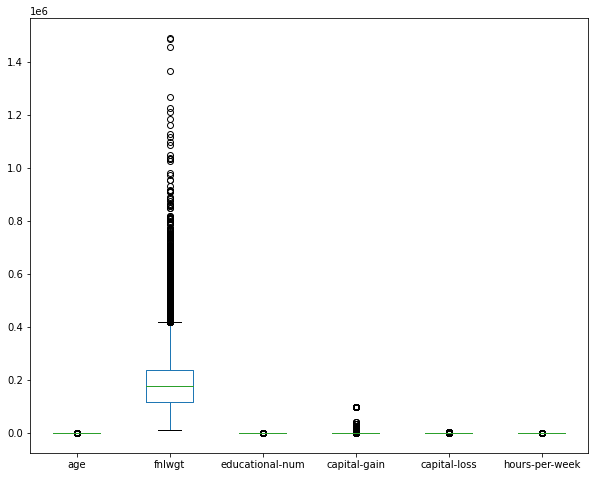

In [14]:
printmd('## Box plot')
adult.select_dtypes(exclude = 'category').plot(kind = 'box', figsize = (10,8))

In [15]:
printmd ('Normalization happens on the training dataset, by removing the mean and \
        scaling to unit variance. These values are stored and then later applied  \
        to the test data before the test data is passed to the model for prediction. ')

Normalization happens on the training dataset, by removing the mean and         scaling to unit variance. These values are stored and then later applied          to the test data before the test data is passed to the model for prediction. 

---
# 4. Model Development & Classification 

## 4.1. Data Preparation'

One-hot encoding is the process of representing multi-class categorical features as binary features, one for each class. Although this process increases the dimensionality of the dataset, classification algorithms tend to work better on this format of data.

I use one-hot encoding to represent all the categorical features in the dataset. 


In [16]:
# Data Prep
adult_data = adult.drop(columns = ['income'])
adult_label = adult.income


adult_cat_1hot = pd.get_dummies(adult_data.select_dtypes('category'))
adult_non_cat = adult_data.select_dtypes(exclude = 'category')

adult_data_1hot = pd.concat([adult_non_cat, adult_cat_1hot], axis=1, join='inner')


In [17]:
def vectorize_sequences(squences, dimension=10000):
    """
    @函数功能:将序列向量化，初始化全0的序列，在单词索引对应的位置上置1
    """
    resluts = np.zeros((len(squences), dimension))
    for i, sequence in enumerate(squences):
        resluts[i, sequence] = 1
    return resluts

In [18]:
def encode_label(label):
  if label == '>50K':
    return 1
  return 0

In [19]:
adult_label.values

['<=50K', '<=50K', '>50K', '>50K', '<=50K', ..., '<=50K', '>50K', '<=50K', '<=50K', '>50K']
Length: 48842
Categories (2, object): ['<=50K', '>50K']

In [20]:
yyyy = np.array( [ encode_label(i) for i in adult_label.values ] )

In [21]:
# Train - Test split
train_data, test_data, train_label, test_label = train_test_split(adult_data_1hot, yyyy, test_size  = 0.25)

In [22]:
train_data

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
32272,28,192588,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
42251,31,208881,10,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
44314,61,197286,4,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10896,27,54897,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
287,46,157857,10,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23802,28,150309,9,0,0,45,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
45851,38,27408,9,0,0,50,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
29788,34,236543,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
342,31,179415,3,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# Normalization
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Fitting only on training data
scaler.fit(train_data)  
train_data = scaler.transform(train_data)  

# Applying same transformation to test data
test_data = scaler.transform(test_data) 

In [24]:
train_label

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
train_data[0].shape

(105,)

In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout

In [45]:
""" 构建神经网络 
不使用正则化和Droupout
使用最基础的Optimizer = SGD
loss = 'binary_crossentropy'
最后输出层使用sigmoid激活函数
"""
model_simple = Sequential()
# keras.regularizers.l1(lambda)
# keras.regularizers.l2(lambda)
# keras.regularizers.l1_l2(l1=lambda1, l2=lambda2)
model_simple.add(Dense(128, activation='tanh', input_shape=train_data[0].shape))
model_simple.add(Dense(64, activation='tanh'))
model_simple.add(Dense(1, activation='sigmoid'))

In [46]:
model_simple.compile(optimizer='SGD',loss = 'binary_crossentropy',metrics=['accuracy'])
history_simple = model_simple.fit(train_data, train_label, epochs=50, batch_size=16, validation_data=(test_data, test_label))


Epoch 1/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3591 - accuracy: 0.8336 - val_loss: 0.3321 - val_accuracy: 0.8455
Epoch 2/50
2290/2290 [==============================] - 5s 2ms/step - loss: 0.3283 - accuracy: 0.8461 - val_loss: 0.3263 - val_accuracy: 0.8466
Epoch 3/50
2290/2290 [==============================] - 5s 2ms/step - loss: 0.3236 - accuracy: 0.8489 - val_loss: 0.3238 - val_accuracy: 0.8473
Epoch 4/50
2290/2290 [==============================] - 5s 2ms/step - loss: 0.3201 - accuracy: 0.8508 - val_loss: 0.3229 - val_accuracy: 0.8523
Epoch 5/50
2290/2290 [==============================] - 5s 2ms/step - loss: 0.3174 - accuracy: 0.8508 - val_loss: 0.3243 - val_accuracy: 0.8467
Epoch 6/50
2290/2290 [==============================] - 5s 2ms/step - loss: 0.3143 - accuracy: 0.8532 - val_loss: 0.3207 - val_accuracy: 0.8491
Epoch 7/50
2290/2290 [==============================] - 5s 2ms/step - loss: 0.3123 - accuracy: 0.8532 - val_loss: 0.3188 - val_accuracy:

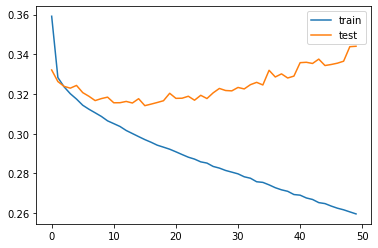

In [47]:
plt.plot(history_simple.history['loss'], label='train')
plt.plot(history_simple.history['val_loss'], label='test')
plt.legend()
plt.show()

In [48]:
""" 构建神经网络 
不使用正则化和Droupout
使用Optimizer = adagrad
loss = 'binary_crossentropy'
最后输出层使用sigmoid激活函数
"""
model_adagrad = Sequential()
# keras.regularizers.l1(lambda)
# keras.regularizers.l2(lambda)
# keras.regularizers.l1_l2(l1=lambda1, l2=lambda2)
model_adagrad.add(Dense(128, activation='tanh', input_shape=train_data[0].shape))
model_adagrad.add(Dense(64, activation='tanh'))
model_adagrad.add(Dense(1, activation='sigmoid'))

In [49]:
model_adagrad.compile(optimizer='Adagrad',loss = 'binary_crossentropy',metrics=['accuracy'])
history_adagrad = model_adagrad.fit(train_data, train_label, epochs=50, batch_size=16, validation_data=(test_data, test_label))

Epoch 1/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.4634 - accuracy: 0.7786 - val_loss: 0.3905 - val_accuracy: 0.8258
Epoch 2/50
2290/2290 [==============================] - 5s 2ms/step - loss: 0.3693 - accuracy: 0.8360 - val_loss: 0.3574 - val_accuracy: 0.8398
Epoch 3/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3494 - accuracy: 0.8419 - val_loss: 0.3452 - val_accuracy: 0.8428
Epoch 4/50
2290/2290 [==============================] - 5s 2ms/step - loss: 0.3407 - accuracy: 0.8438 - val_loss: 0.3390 - val_accuracy: 0.8452
Epoch 5/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3358 - accuracy: 0.8461 - val_loss: 0.3354 - val_accuracy: 0.8464
Epoch 6/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3327 - accuracy: 0.8463 - val_loss: 0.3334 - val_accuracy: 0.8469
Epoch 7/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3305 - accuracy: 0.8469 - val_loss: 0.3314 - val_accuracy:

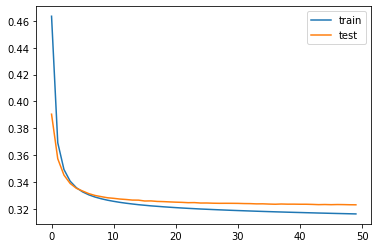

In [50]:
plt.plot(history_adagrad.history['loss'], label='train')
plt.plot(history_adagrad.history['val_loss'], label='test')
plt.legend()
plt.show()

In [74]:
""" 构建神经网络 
不使用正则化和Droupout
使用Optimizer = adam
loss = 'binary_crossentropy'
最后输出层使用sigmoid激活函数
"""
model_adam = Sequential()
# keras.regularizers.l1(lambda)
# keras.regularizers.l2(lambda)
# keras.regularizers.l1_l2(l1=lambda1, l2=lambda2)
model_adam.add(Dense(128, activation='tanh', input_shape=train_data[0].shape))
model_adam.add(Dense(64, activation='tanh'))
model_adam.add(Dense(1, activation='sigmoid'))

In [75]:
model_adam.compile(optimizer='Adam',loss = 'binary_crossentropy',metrics=['accuracy'])
history_adam = model_adam.fit(train_data, train_label, epochs=50, batch_size=16, validation_data=(test_data, test_label))

Epoch 1/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3439 - accuracy: 0.8386 - val_loss: 0.3267 - val_accuracy: 0.8447
Epoch 2/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3171 - accuracy: 0.8513 - val_loss: 0.3145 - val_accuracy: 0.8510
Epoch 3/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3093 - accuracy: 0.8543 - val_loss: 0.3134 - val_accuracy: 0.8519
Epoch 4/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3014 - accuracy: 0.8591 - val_loss: 0.3114 - val_accuracy: 0.8517
Epoch 5/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.2957 - accuracy: 0.8610 - val_loss: 0.3094 - val_accuracy: 0.8547
Epoch 6/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.2899 - accuracy: 0.8655 - val_loss: 0.3134 - val_accuracy: 0.8564
Epoch 7/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.2846 - accuracy: 0.8682 - val_loss: 0.3130 - val_accuracy:

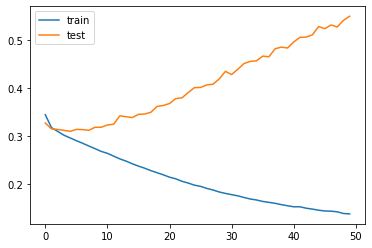

In [76]:
plt.plot(history_adam.history['loss'], label='train')
plt.plot(history_adam.history['val_loss'], label='test')
plt.legend()
plt.show()

In [52]:
""" 构建神经网络 
不使用正则化
使用Dropout
使用Optimizer = adam
loss = 'binary_crossentropy'
最后输出层使用sigmoid激活函数
"""
model_dropout = Sequential()
# keras.regularizers.l1(lambda)
# keras.regularizers.l2(lambda)
# keras.regularizers.l1_l2(l1=lambda1, l2=lambda2)
model_dropout.add(Dense(128, activation='tanh', input_shape=train_data[0].shape))
model_dropout.add(Dense(64, activation='tanh'))
model_dropout.add(Dropout(0.25))
model_dropout.add(Dense(1, activation='sigmoid'))

In [53]:
model_dropout.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
history_dropout = model_dropout.fit(train_data, train_label, epochs=50, batch_size=16, validation_data=(test_data, test_label))

Epoch 1/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3508 - accuracy: 0.8347 - val_loss: 0.3246 - val_accuracy: 0.8505
Epoch 2/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3264 - accuracy: 0.8465 - val_loss: 0.3267 - val_accuracy: 0.8448
Epoch 3/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3186 - accuracy: 0.8525 - val_loss: 0.3164 - val_accuracy: 0.8529
Epoch 4/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.3138 - accuracy: 0.8541 - val_loss: 0.3135 - val_accuracy: 0.8509
Epoch 5/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3097 - accuracy: 0.8554 - val_loss: 0.3150 - val_accuracy: 0.8503
Epoch 6/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3046 - accuracy: 0.8583 - val_loss: 0.3129 - val_accuracy: 0.8556
Epoch 7/50
2290/2290 [==============================] - 6s 2ms/step - loss: 0.2995 - accuracy: 0.8618 - val_loss: 0.3122 - val_accuracy:

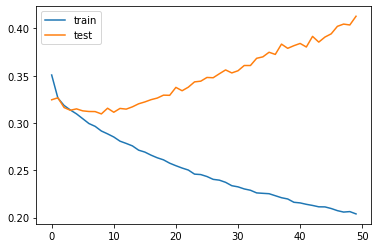

In [54]:
plt.plot(history_dropout.history['loss'], label='train')
plt.plot(history_dropout.history['val_loss'], label='test')
plt.legend()
plt.show()

In [55]:
""" 构建神经网络 
使用l2正则化不使用Dropout
使用Optimizer = adam
loss = 'binary_crossentropy'
最后输出层使用sigmoid激活函数
"""
model_l2 = Sequential()
# keras.regularizers.l1(lambda)
# keras.regularizers.l2(lambda)
# keras.regularizers.l1_l2(l1=lambda1, l2=lambda2)
model_l2.add(Dense(128, activation='tanh', input_shape=train_data[0].shape,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_l2.add(Dense(64, activation='tanh'))
model_l2.add(Dense(1, activation='sigmoid'))

In [56]:
model_l2.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
history_l2 = model_l2.fit(train_data, train_label, epochs=50, batch_size=16, validation_data=(test_data, test_label))

Epoch 1/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.4362 - accuracy: 0.8370 - val_loss: 0.3525 - val_accuracy: 0.8446
Epoch 2/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3498 - accuracy: 0.8442 - val_loss: 0.3429 - val_accuracy: 0.8457
Epoch 3/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3454 - accuracy: 0.8466 - val_loss: 0.3448 - val_accuracy: 0.8478
Epoch 4/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3438 - accuracy: 0.8462 - val_loss: 0.3394 - val_accuracy: 0.8483
Epoch 5/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3427 - accuracy: 0.8468 - val_loss: 0.3390 - val_accuracy: 0.8505
Epoch 6/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3420 - accuracy: 0.8468 - val_loss: 0.3362 - val_accuracy: 0.8481
Epoch 7/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3396 - accuracy: 0.8482 - val_loss: 0.3350 - val_accuracy:

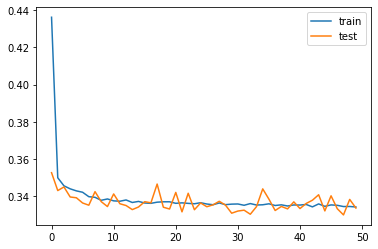

In [57]:
plt.plot(history_l2.history['loss'], label='train')
plt.plot(history_l2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [58]:
""" 构建神经网络 
使用l1正则化不使用Dropout
使用Optimizer = adam
loss = 'binary_crossentropy'
最后输出层使用sigmoid激活函数
"""
model_l1 = Sequential()
# keras.regularizers.l1(lambda)
# keras.regularizers.l2(lambda)
# keras.regularizers.l1_l2(l1=lambda1, l2=lambda2)
model_l1.add(Dense(128, activation='tanh', input_shape=train_data[0].shape,kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model_l1.add(Dense(64, activation='tanh'))
model_l1.add(Dense(1, activation='sigmoid'))

In [59]:
model_l1.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
history_l1 = model_l1.fit(train_data, train_label, epochs=50, batch_size=16, validation_data=(test_data, test_label))

Epoch 1/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.7422 - accuracy: 0.8403 - val_loss: 0.3861 - val_accuracy: 0.8451
Epoch 2/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3775 - accuracy: 0.8475 - val_loss: 0.3730 - val_accuracy: 0.8451
Epoch 3/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3728 - accuracy: 0.8466 - val_loss: 0.3649 - val_accuracy: 0.8476
Epoch 4/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3733 - accuracy: 0.8472 - val_loss: 0.3595 - val_accuracy: 0.8494
Epoch 5/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3726 - accuracy: 0.8467 - val_loss: 0.3656 - val_accuracy: 0.8451
Epoch 6/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3725 - accuracy: 0.8472 - val_loss: 0.3712 - val_accuracy: 0.8486
Epoch 7/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.3780 - accuracy: 0.8463 - val_loss: 0.3902 - val_accuracy:

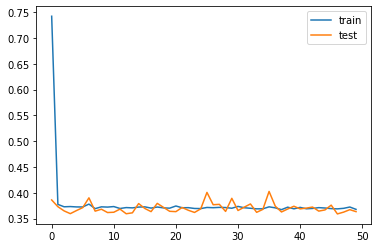

In [60]:
plt.plot(history_l1.history['loss'], label='train')
plt.plot(history_l1.history['val_loss'], label='test')
plt.legend()
plt.show()

In [77]:
""" 构建神经网络 
使用l1正则化不使用Dropout
使用Optimizer = adagrad
loss = 'binary_crossentropy'
最后输出层使用sigmoid激活函数
"""
model_l1_Adagrad = Sequential()
# keras.regularizers.l1(lambda)
# keras.regularizers.l2(lambda)
# keras.regularizers.l1_l2(l1=lambda1, l2=lambda2)
model_l1_Adagrad.add(Dense(128, activation='tanh', input_shape=train_data[0].shape,kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model_l1_Adagrad.add(Dense(64, activation='tanh'))
model_l1_Adagrad.add(Dense(1, activation='sigmoid'))

In [78]:
model_l1_Adagrad.compile(optimizer='Adagrad',loss = 'binary_crossentropy',metrics=['accuracy'])
history_l1_Adagrad = model_l1_Adagrad.fit(train_data, train_label, epochs=50, batch_size=16, validation_data=(test_data, test_label))

Epoch 1/50
2290/2290 [==============================] - 7s 3ms/step - loss: 8.0088 - accuracy: 0.7891 - val_loss: 5.6487 - val_accuracy: 0.8382
Epoch 2/50
2290/2290 [==============================] - 6s 3ms/step - loss: 4.2595 - accuracy: 0.8371 - val_loss: 3.1335 - val_accuracy: 0.8398
Epoch 3/50
2290/2290 [==============================] - 6s 3ms/step - loss: 2.3868 - accuracy: 0.8398 - val_loss: 1.7649 - val_accuracy: 0.8410
Epoch 4/50
2290/2290 [==============================] - 6s 3ms/step - loss: 1.3524 - accuracy: 0.8396 - val_loss: 1.0147 - val_accuracy: 0.8410
Epoch 5/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.8219 - accuracy: 0.8391 - val_loss: 0.6764 - val_accuracy: 0.8416
Epoch 6/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.6153 - accuracy: 0.8385 - val_loss: 0.5624 - val_accuracy: 0.8414
Epoch 7/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.5354 - accuracy: 0.8387 - val_loss: 0.5065 - val_accuracy:

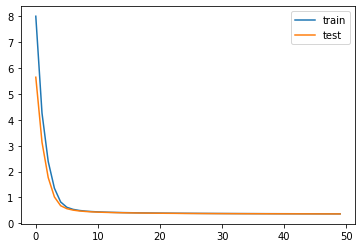

In [80]:
plt.plot(history_l1_Adagrad.history['loss'], label='train')
plt.plot(history_l1_Adagrad.history['val_loss'], label='test')
plt.legend()
plt.show()

In [71]:
""" 构建神经网络 
使用l2_l1正则化
使用Dropout
使用Optimizer = adam
loss = 'binary_crossentropy'
最后输出层使用sigmoid激活函数
"""
model = Sequential()
# keras.regularizers.l1(lambda)
# keras.regularizers.l2(lambda)
# keras.regularizers.l1_l2(l1=lambda1, l2=lambda2)
model.add(Dense(128, activation='tanh', input_shape=train_data[0].shape,kernel_regularizer=tf.keras.regularizers.l1_l2(0.05,0.05)))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

In [72]:
model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_data, train_label, epochs=50, batch_size=16, validation_data=(test_data, test_label))

Epoch 1/50
2290/2290 [==============================] - 6s 3ms/step - loss: 2.0142 - accuracy: 0.8287 - val_loss: 0.4856 - val_accuracy: 0.8451
Epoch 2/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.4928 - accuracy: 0.8436 - val_loss: 0.4749 - val_accuracy: 0.8457
Epoch 3/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.4870 - accuracy: 0.8411 - val_loss: 0.4802 - val_accuracy: 0.8432
Epoch 4/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.4826 - accuracy: 0.8435 - val_loss: 0.4801 - val_accuracy: 0.8473
Epoch 5/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.4841 - accuracy: 0.8416 - val_loss: 0.4710 - val_accuracy: 0.8443
Epoch 6/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.4841 - accuracy: 0.8434 - val_loss: 0.4677 - val_accuracy: 0.8465
Epoch 7/50
2290/2290 [==============================] - 6s 3ms/step - loss: 0.4839 - accuracy: 0.8432 - val_loss: 0.4752 - val_accuracy:

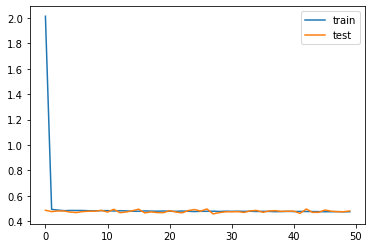

In [73]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [64]:
salary_pre = model.predict(test_data)
for i,j in zip(salary_pre , test_label):
  if j == 1:
    print(i,j,end=' ')
    # input(   )

[0.8672245] 1 [0.8072985] 1 [0.47682205] 1 [0.45370755] 1 [0.3791679] 1 [0.28759196] 1 [0.2476546] 1 [0.36525434] 1 [0.78868926] 1 [0.2955238] 1 [0.8208797] 1 [0.78580475] 1 [0.73121023] 1 [0.59865737] 1 [0.68776244] 1 [0.65119356] 1 [0.2609322] 1 [0.5312864] 1 [0.5117241] 1 [0.7947812] 1 [0.424385] 1 [0.47382307] 1 [0.907853] 1 [0.70427567] 1 [0.9366414] 1 [0.80253637] 1 [0.9037702] 1 [0.64478385] 1 [0.37833926] 1 [0.1494762] 1 [0.9281676] 1 [0.82025737] 1 [0.30001748] 1 [0.38149694] 1 [0.8395353] 1 [0.87210816] 1 [0.23839742] 1 [0.5685707] 1 [0.31166723] 1 [0.5206632] 1 [0.38588652] 1 [0.5634514] 1 [0.42347243] 1 [0.41464186] 1 [0.66616964] 1 [0.52501667] 1 [0.72498405] 1 [0.63515264] 1 [0.43086928] 1 [0.5584419] 1 [0.1423596] 1 [0.76013917] 1 [0.26016173] 1 [0.8205706] 1 [0.4221086] 1 [0.22899607] 1 [0.09941889] 1 [0.47754055] 1 [0.44080207] 1 [0.9263958] 1 [0.41438952] 1 [0.49576408] 1 [0.576951] 1 [0.4628839] 1 [0.70781285] 1 [0.5538138] 1 [0.5263795] 1 [0.66866976] 1 [0.8506853] 

---
# 5. Conclusion

I choose **Adaboost** model as my preferred my approach. The Adaboost model not only has the **highest accuracy**, but also has the **highest precision and F-measure** of all the models developed as a part of this analysis. The advantages of using Adaboost over other models is that they are very simple to implement. Since they are made up of weak individual learners, they are less susceptible to overfitting. However, Adaboost is sensitive to noisy data and outliers. 
